In [100]:
import pandas as pd
import numpy as np
import tqdm
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

pd.set_option("max_rows", 200)
pd.set_option("max_columns", 50)
tqdm.tqdm.pandas()
%matplotlib inline

In [101]:
df = pd.read_pickle("../input/riiid-test-answer-prediction/split10/train_0.pickle").sort_values(["user_id", "timestamp"]).reset_index(drop=True)

In [102]:
import sys
sys.path.append("../")
# df = pd.read_pickle("../input/riiid-test-answer-prediction/split10/train_0.pickle")
df = df.sort_values(["user_id", "timestamp"])
# large_user_id = df["user_id"].value_counts()
# large_user_id = large_user_id[large_user_id > 1000] 
# df = df[df["user_id"].isin(large_user_id.index)]
# df = df[df["answered_correctly"] != -1]
df["answered_correctly"] = df["answered_correctly"].replace(-1, np.nan)

In [103]:
w_df = df[["user_id", "task_container_id", "timestamp", "prior_question_elapsed_time"]]
w_df = w_df.drop_duplicates(["user_id", "task_container_id"])

In [104]:
w_df["elapsed_time"] = w_df.groupby(["user_id"])["prior_question_elapsed_time"].shift(-1)

In [105]:
df = pd.merge(df, w_df[["user_id", "task_container_id", "elapsed_time"]])

In [108]:
df["timediff"] = df["timestamp"] - df.groupby(["user_id"])["timestamp"].shift()
df["timediff"] = df["timediff"].replace(0, np.nan).fillna(method="ffill") / df.groupby(["user_id", "task_container_id"])["user_id"].transform("count")

In [140]:
df["timediff"] = [x if x < 100000 else np.nan for x in df["timediff"].values]

In [141]:
df["elapsed_time_contentmean"] = df.groupby("content_id")["elapsed_time"].transform("mean")

In [142]:
df["user_id"]

0                24600
1                24600
2                24600
3                24600
4                24600
               ...    
10033861    2147481750
10033862    2147481750
10033863    2147481750
10033864    2147481750
10033865    2147481750
Name: user_id, Length: 10033866, dtype: int32

In [143]:
df["elapsedtime_timediff"] = df["timediff"] - df["elapsed_time"]

In [150]:
df["user_elapsed-timediff"] = df.groupby("user_id")["elapsedtime_timediff"].transform("mean")

In [151]:
df[["task_container_id", "elapsed_time", "timediff", "elapsed_time_contentmean", "elapsedtime_timediff", "user_elapsed-timediff"]].head(10)

,task_container_id,elapsed_time,timediff,elapsed_time_contentmean,elapsedtime_timediff,user_elapsed-timediff
0,0,24000.0,NaN,22459.290654,NaN,4951.130435
1,1,23000.0,25379.000000,22857.767120,2379.000000,4951.130435
2,2,22000.0,24758.000000,24149.111445,2758.000000,4951.130435
3,3,18000.0,20044.000000,18189.783611,2044.000000,4951.130435
4,4,24333.0,26140.000000,25755.408418,1807.000000,4951.130435
5,4,24333.0,26140.000000,25755.408418,1807.000000,4951.130435
6,4,24333.0,26140.000000,25755.408418,1807.000000,4951.130435
7,5,22000.0,23584.333333,22639.306757,1584.333333,4951.130435
8,5,22000.0,23584.333333,22639.306757,1584.333333,4951.130435
9,5,22000.0,23584.333333,22639.306757,1584.333333,4951.130435


In [152]:
df["timediff_mean"] = df.groupby(["content_id", "prior_question_had_explanation"])["timediff"].transform("mean")
df["timediff_median"] = df.groupby(["content_id", "prior_question_had_explanation"])["timediff"].transform("mean")

In [153]:
df[["task_container_id", "elapsed_time", "timediff", "timediff_mean", "timediff_median", "elapsed_time_contentmean", "elapsedtime_timediff", "user_elapsed-timediff"]].head(10)

,task_container_id,elapsed_time,timediff,timediff_mean,timediff_median,elapsed_time_contentmean,elapsedtime_timediff,user_elapsed-timediff
0,0,24000.0,NaN,NaN,NaN,22459.290654,NaN,4951.130435
1,1,23000.0,25379.000000,26640.066289,26640.066289,22857.767120,2379.000000,4951.130435
2,2,22000.0,24758.000000,27566.716711,27566.716711,24149.111445,2758.000000,4951.130435
3,3,18000.0,20044.000000,22151.831535,22151.831535,18189.783611,2044.000000,4951.130435
4,4,24333.0,26140.000000,30473.408455,30473.408455,25755.408418,1807.000000,4951.130435
5,4,24333.0,26140.000000,30473.408455,30473.408455,25755.408418,1807.000000,4951.130435
6,4,24333.0,26140.000000,30473.408455,30473.408455,25755.408418,1807.000000,4951.130435
7,5,22000.0,23584.333333,26674.547648,26674.547648,22639.306757,1584.333333,4951.130435
8,5,22000.0,23584.333333,26674.547648,26674.547648,22639.306757,1584.333333,4951.130435
9,5,22000.0,23584.333333,26674.547648,26674.547648,22639.306757,1584.333333,4951.130435


In [154]:
df[["task_container_id", "elapsed_time", "timediff", "timediff_mean", "timediff_median", "elapsed_time_contentmean", "elapsedtime_timediff", "user_elapsed-timediff"]].tail(10)

,task_container_id,elapsed_time,timediff,timediff_mean,timediff_median,elapsed_time_contentmean,elapsedtime_timediff,user_elapsed-timediff
10033856,40,16000.0,NaN,44672.806344,44672.806344,28318.181818,NaN,9046.130435
10033857,41,23000.0,30099.0,50514.931164,50514.931164,35305.581835,7099.0,9046.130435
10033858,42,15000.0,22470.0,43647.612075,43647.612075,27349.831471,7470.0,9046.130435
10033859,43,24000.0,30096.0,41549.115895,41549.115895,24103.737690,6096.0,9046.130435
10033860,44,3000.0,9296.0,35915.923111,35915.923111,17925.000000,6296.0,9046.130435
10033861,45,28000.0,34075.0,35185.406332,35185.406332,18775.000000,6075.0,9046.130435
10033862,46,14000.0,20962.0,41556.326577,41556.326577,22742.907801,6962.0,9046.130435
10033863,47,20000.0,26141.0,36657.987552,36657.987552,20168.053245,6141.0,9046.130435
10033864,48,21000.0,27588.0,39303.221947,39303.221947,22171.372931,6588.0,9046.130435
10033865,49,NaN,16213.0,33324.409794,33324.409794,16902.272727,NaN,9046.130435


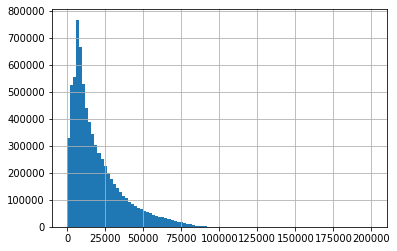

In [155]:
df["elapsedtime_timediff"].hist(bins=100, range=(0, 200000))

In [21]:
df.head(100)

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,question_id,bundle_id,correct_answer,part,tags,tag,type_of,elapsed_time,timediff,elapsed_time_partmean,elapsed_time_contentmean
0,0,24600,7900,0,0,0,1.0,NaN,NaN,7900,7900,0,1,131 93 81,-1,NaN,24000.0,NaN,22459.290654,22459.290654
1,25379,24600,7876,0,1,2,0.0,24000.0,False,7876,7876,3,1,10 94 92,-1,NaN,23000.0,25379.0,22857.767120,22857.767120
2,50137,24600,175,0,2,2,1.0,23000.0,False,175,175,2,1,9 10 92,-1,NaN,22000.0,24758.0,24149.111445,24149.111445
3,70181,24600,1278,0,3,3,1.0,22000.0,False,1278,1278,3,2,143 140 81 29,-1,NaN,18000.0,20044.0,18189.783611,18189.783611
4,148601,24600,2064,0,4,2,0.0,18000.0,False,2064,2063,1,3,157 92 29,-1,NaN,18000.0,78420.0,21021.048323,21021.048323
5,148601,24600,2065,0,4,2,1.0,18000.0,False,2065,2063,2,3,136 162 92 29,-1,NaN,18000.0,78420.0,21370.209975,21370.209975
6,148601,24600,2063,0,4,1,0.0,18000.0,False,2063,2063,0,3,136 92 29,-1,NaN,24333.0,78420.0,21183.244187,21183.244187
7,219354,24600,3364,0,5,0,0.0,24333.0,False,3364,3363,1,4,136 103 29,-1,NaN,24333.0,70753.0,24775.365426,24775.365426
8,219354,24600,3365,0,5,1,0.0,24333.0,False,3365,3363,2,4,136 103 29,-1,NaN,24333.0,70753.0,24502.288007,24502.288007
9,219354,24600,3363,0,5,2,0.0,24333.0,False,3363,3363,3,4,74 103 29,-1,NaN,22000.0,70753.0,24604.883480,24604.883480
